TODO:
   - [ ] перевести формирование счетчика навыков в функцию
   - [ ] добавить обьединенную сортировку по заработной плате
   - [ ] на основе вышеприведенных пунктовЖ добавить просмотр навыков по 0.XX самым высокооплачиваемым вакансиям
   - [x] try - except блок при загрузке данных с сайта
   - [ ] сделать приложением?

In [108]:
import requests
from tqdm.notebook import tqdm
from datetime import datetime
from dateutil.parser import parse

import re
import time
from collections import Counter

import pandas as pd

In [2]:
#dir(requests)

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\_v010ch_\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
addr = 'https://api.hh.ru/vacancies'
head = {'User-Agent': 'NoApp'}

In [21]:
vacancies_list = [ 'Data scientist',
'Data science', 
'Ml specialist', 
'Machine learning', 
#'Data Analyst',
#'master data',
'ML']

'area': {'id': '1', 'name': 'Москва'...}    
'salary': {'from': 300000, 'to': None, 'currency': 'RUR', 'gross': False}    
'description': {'......'}    
'key_skills': [{'name': 'Мат стат'}, {'name': 'Мат анализ'}, {'name': 'Python'}, {'name': 'Git'}]     
'published_at': YYYY-MM-DDThh:mm:ss±hhmm

### Забираем данные по вакансиям с hh

In [22]:
clr = lambda x: (re.sub(r'<.*?>', '', str(x)))
BREAK_STOP_LEVEL = 3

In [187]:
%%time

id_list     = list()
area_list   = list()
descr_list  = list()
salary_from_list = list()
salary_to_list   = list()
salary_cur_list  = list()
key_skills_list  = list()

date_list = list()

breaks_count = 0

for element in vacancies_list:
    new_ones = 0
    
    #getting amount of all vacancies
    try:
        answ = requests.get(addr, params={'text':element}, headers = head)
        if answ.status_code != 200:
            print('Error get info with ' + element + ' tag')
            break
    except:
        print('exception try to get list of vacansies for profession')
        breaks_count += 1
        print('end')
        break
        
    print(answ.url)
    time.sleep(1)
    
    info_tag = answ.json()
    amnt_pages = info_tag['pages']
    amnt_found = info_tag['found']
    
    # amnt_pages
    for page in tqdm(range(amnt_pages)):
        # going through all pages
        try:
            answ = requests.get(addr, params={'text':element, 'page':page}, headers = head)
            if answ.status_code != 200:
                print('Error get info with ' + element + ' tag on page ' + str(page))
                break
        except:
            print(f'exception try to get next list of vacansies for {element}')
            breaks_count += 1
            if breaks_count > BREAK_STOP_LEVEL:
                break
            continue
            
        info_tag_page = answ.json()
        info_tag_page = info_tag_page['items']
        if len(info_tag_page) == 0:
            break
        
        #len(info_tag_page)
        for vac in range( len(info_tag_page) ):
            #going through all vacancies on pages 
            if info_tag_page[vac]['id'] in id_list:
                break
            
            try:
                #print(info_tag_page[vac]['id'])
                answ = requests.get(addr + '/' + info_tag_page[vac]['id'], headers = head)
                if answ.status_code != 200:
                    print('Error get info about vacancia ' + info_tag_page[vac]['id'])
                    break  
            except:
                print('exception try to get vacancy description')
                breaks_count += 1
                if breaks_count > BREAK_STOP_LEVEL:
                    break
                continue
            vacancy = answ.json()
            
            id_list.append(vacancy['id'])
            
            if isinstance(vacancy['area'], type(None)):
                area_list.append('')
            else:
                area_list.append(  vacancy['area']['name'].lower())  # id name
            
            if isinstance(vacancy['description'], type(None)):
                descr_list.append('')
            else:
                descr_list.append(  clr(vacancy['description']).lower())  # id name
            
            
            if isinstance(vacancy['salary'], type(None)):
                salary_from_list.append( None )   # from to
                salary_to_list.append(   None )   # from to
                salary_cur_list.append(  None )
            else:
                salary_from_list.append( vacancy['salary']['from']) # from to
                salary_to_list.append(   vacancy['salary']['to'])   # from to
                salary_cur_list.append(  vacancy['salary']['currency'].lower())
            
                        
            #if len(vacancy['key_skills']) > 0:
            #    for skill in range( len(vacancy['key_skills']) ):   # name name name name.....
            #        key_skills_list.append(  vacancy['key_skills'][skill]['name'].lower())
            key_skills_list.append(  vacancy['key_skills'] )   
            
            date_list.append( parse(vacancy['published_at'], ignoretz = True) )
            new_ones += 1
                   
    print('Found ' + str(amnt_found) + ' vacancies with key words "' + element + '" with ' + str(new_ones) + ' not in list')
    
    
print('\nDone')

https://api.hh.ru/vacancies?text=Data+scientist



Found 558 vacancies with key words "Data scientist" with 558 not in list
https://api.hh.ru/vacancies?text=Data+science



Found 1306 vacancies with key words "Data science" with 745 not in list
https://api.hh.ru/vacancies?text=Ml+specialist



Found 213 vacancies with key words "Ml specialist" with 39 not in list
https://api.hh.ru/vacancies?text=Machine+learning



Found 829 vacancies with key words "Machine learning" with 159 not in list
https://api.hh.ru/vacancies?text=ML



Found 1084 vacancies with key words "ML" with 110 not in list

Done


### Зачищаем вакансии так, что бы при наличии в одной вакансии нескольких библиотек js, оставался бы только один js. и т.п.

In [188]:
key_skills_list[:5]

[[],
 [],
 [{'name': 'Python'},
  {'name': 'Big Data'},
  {'name': 'Tableau'},
  {'name': 'Базы данных'}],
 [{'name': 'Python'},
  {'name': 'Прогнозирование'},
  {'name': 'Аналитические исследования'},
  {'name': 'MS PowerPoint'},
  {'name': 'Data Mining'},
  {'name': 'Pytorch'},
  {'name': 'Scikit-learn'},
  {'name': 'Sklearn'},
  {'name': 'Scikit learn'},
  {'name': 'TensorFlow'},
  {'name': 'DataScience'},
  {'name': 'Data Science'},
  {'name': 'Анализ данных'}],
 []]

In [189]:
# для обьединения
javascript_list = ['javascript', 'node.js', 'js', 'react', 'react.js', 'reactjs', 'jquery', 'angularjs', 'jquery', 'vue.js', 'vuejs', 'vue', 'backbone', 'redux']

skill_dict = {'анализ данных':'data analysis', 'машинное обучение':'machine learning',
              'ml':'machine learning', 'разработка по':'software development',
              'data scientist': 'data science',
              'opencv': 'computoe vision', 'cv': 'computoe vision', 'компьютерное зрение': 'computoe vision',
              'анализ данных':'data analysis', 'бизнес-анализ':'business analysis',
              'базы данных':'работа с базами данных', 'html5':'html', 
              'проведение презентаций':'presentation skills',
              #?'тестирование': 'a/b', 'qa'
              'kubernetes': 'kubernates',
              'k8s': 'kubernates',
              'marketing analysis': 'маркетинговый анализ',
              'analytical skills': 'аналитическое мышление',
              'cистемы управления базами данных': 'cубд',
              'ms access': 'office', 'ms powerpoint': 'office', 'ms excel': 'office',
              'ms office': 'office', 'ms visio': 'office', 'ms outlook': 'office',#'ms project': 'office', 
              'ms sharepoint': 'office', 
              'powerbi': 'ms power bi',
              'power bi': 'ms power bi',
              'rest api': 'rest',
              'ruby on rails': 'ruby',
              'natural language processing': 'nlp',
              'go': 'golang',
              'negotiation skills': 'ведение переговоров',
              'bigquery': 'google bigquery',
             }
for_change = skill_dict.keys()

In [190]:
key_skills = Counter()
for el in tqdm(key_skills_list):
    if len(el) > 1:
        skills = []
        for ind in range(len(el)):
            element = el[ind]['name'].lower()
            
            if 'sql' in element and 'nosql' not in element:
                skills.append('sql')
            elif 'english' in element:
                skills.append('английский язык')
            elif 'c++' in element or 'c' == element:
                skills.append('c/c++')
            elif element in javascript_list:   # should be earlie then 'java'
                skills.append('javascript')
            elif element.startswith('java'):
                skills.append('java')
            elif element.startswith('hadoop'):
                skills.append('hadoop')
                
            elif element.startswith('css'):
                skills.append('css')
                
            elif 'nosql' in element:
                skills.append('nosql')
            elif element.startswith('qa'):
                skills.append('qa')
            elif element.startswith('a/b'):
                skills.append('a/b')
            elif 'тест' in element:
                skills.append('qa')
            elif 'nlp' in element:
                skills.append('nlp')
            elif 'продаж' in element or 'холод' in element:
                skills.append('ignored skills')
            else:
                skills.append(element)
            
            if skills[-1] in for_change:
                skills[-1] = skill_dict[skills[-1]]

        key_skills += Counter(set(skills))

Посмотрим на требуемые скилы в вакансиях

In [191]:
show_butch = 0 # какую группу по 50 скилов отображать

for_print = key_skills.most_common()[show_butch*50 : show_butch*50 + 50]
#for_print = key_skills.most_common()[-1*show_butch*50 - 50 : -1*show_butch*50 ]
for el in for_print:
    print(f'{el[1]:3}  {el[0]}')

586  python
522  sql
241  английский язык
166  linux
159  java
155  data mining
144  git
139  data analysis
130  c/c++
127  javascript
113  machine learning
107  office
 92  математическая статистика
 72  работа с базами данных
 66  data science
 64  аналитическое мышление
 61  управление проектами
 59  agile project management
 58  hadoop
 58  c#
 56  big data
 50  docker
 49  spark
 48  html
 47  css
 45  spring framework
 42  project management
 41  tensorflow
 41  qa
 40  математический анализ
 40  scala
 39  business analysis
 38  matlab
 37  aws
 35  аналитические исследования
 35  статистический анализ
 35  kubernates
 34  google analytics
 33  pandas
 33  crm
 32  работа в команде
 32  mongodb
 32  product management
 32  .net framework
 31  математическое моделирование
 31  nlp
 31  team management
 30  разработка технических заданий
 30  leadership skills
 27  pytorch


### Посмотрим на оплату

In [192]:
df_slr = pd.DataFrame({'slr_from':salary_from_list, 'slr_to':salary_to_list, 'slr_cur':salary_cur_list})
df_slr.shape

(1611, 3)

In [193]:
df_slr.head()

,slr_from,slr_to,slr_cur
0,100000.0,NaN,rur
1,NaN,NaN,None
2,150000.0,200000.0,rur
3,170000.0,230000.0,rur
4,70000.0,100000.0,rur


In [194]:
df_slr[df_slr.slr_cur == 'rur'].slr_from.dropna().shape, df_slr[['slr_from', 'slr_to']].slr_from.dropna().shape

((179,), (248,))

{'whiskers': [<matplotlib.lines.Line2D at 0x24591bae748>,
 'caps': [<matplotlib.lines.Line2D at 0x24591bd0208>,
 'boxes': [<matplotlib.lines.Line2D at 0x24591bb0b08>],
 'medians': [<matplotlib.lines.Line2D at 0x24591bd83c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x24591bd8d88>],
 'means': []}

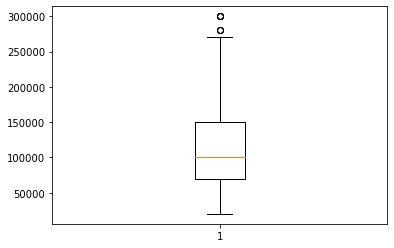

In [195]:
plt.boxplot( df_slr[df_slr.slr_cur == 'rur'].slr_from.drop(df_slr[df_slr.slr_cur == 'rur'].slr_from.idxmax()).dropna() )

{'whiskers': [<matplotlib.lines.Line2D at 0x2458c696748>,
 'caps': [<matplotlib.lines.Line2D at 0x24591a70248>,
 'boxes': [<matplotlib.lines.Line2D at 0x24591a79e48>],
 'medians': [<matplotlib.lines.Line2D at 0x24591204808>],
 'fliers': [<matplotlib.lines.Line2D at 0x24591a02788>],
 'means': []}

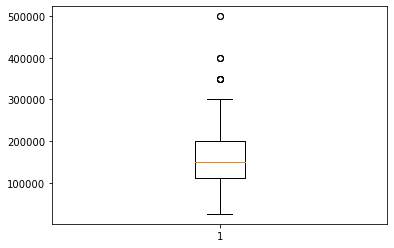

In [196]:
#plt.boxplot( df_slr[df_slr.slr_cur == 'rur'].slr_to.dropna() )
plt.boxplot( df_slr[df_slr.slr_cur == 'rur'].slr_to.drop(df_slr[df_slr.slr_cur == 'rur'].slr_to.idxmax()).dropna() )

если предположить, что все вакансии с оплатой больше 30000 в рублях

{'whiskers': [<matplotlib.lines.Line2D at 0x245933b0888>,
 'caps': [<matplotlib.lines.Line2D at 0x245933d3908>,
 'boxes': [<matplotlib.lines.Line2D at 0x245933cc448>],
 'medians': [<matplotlib.lines.Line2D at 0x245933da708>],
 'fliers': [<matplotlib.lines.Line2D at 0x245933dadc8>],
 'means': []}

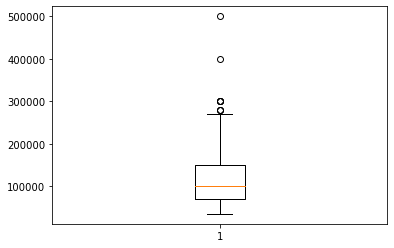

In [222]:
plt.boxplot( df_slr.query('slr_from <= 800000 and slr_from > 30000').slr_from.dropna())

{'whiskers': [<matplotlib.lines.Line2D at 0x24593421c48>,
 'caps': [<matplotlib.lines.Line2D at 0x24593438d88>,
 'boxes': [<matplotlib.lines.Line2D at 0x24593436a48>],
 'medians': [<matplotlib.lines.Line2D at 0x24593442b48>],
 'fliers': [<matplotlib.lines.Line2D at 0x24593442b08>],
 'means': []}

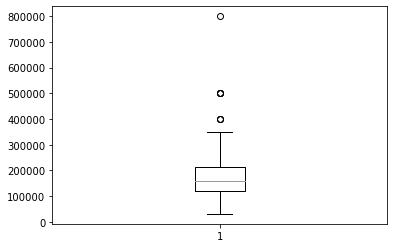

In [223]:
plt.boxplot( df_slr.query('slr_to <= 800000 and slr_to > 30000').slr_to.dropna())

#### test

In [6]:
answ = requests.get(addr, params = {'text':'ML'}, headers = head)
print(len(answ.json(), answ.status_code)

In [8]:
answ.status_code

200

In [9]:
info = answ.json()
print( info['found'] )
print( info['pages'] )
print( len(info['items']) )

print( info['items'][0]['id'] )

571
29
20
36292283


In [15]:
answ = requests.get(addr + '/' + str(35218725), headers = head)
vac = answ.json()
#vac

In [25]:
vac

{'id': '35218725',
 'premium': False,
 'billing_type': {'id': 'standard_plus', 'name': 'Стандарт плюс'},
 'relations': [],
 'name': 'Junior Data scientist',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': None,
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': {'city': 'Москва',
  'street': 'улица 8 Марта',
  'building': '1с12',
  'description': None,
  'lat': 55.800726,
  'lng': 37.554933,
  'raw': 'Москва, улица 8 Марта, 1с12',
  'metro': {'station_name': 'Динамо',
   'line_name': 'Замоскворецкая',
   'station_id': '2.34',
   'line_id': '2',
   'lat': 55.789704,
   'lng': 37.558212},
  'metro_stations': [{'station_name': 'Динамо',
    'line_name': 'Замоскворецкая',
    'station_id': '2.34',
    'line_id': '2',
    'lat': 55.789704,
    'lng': 37.558212},
   {'station_name': 'Петровский парк',
    'line_name': 'Солнцевская',
    'station_id': '133.594',
    'line_id': '133',
 

In [8]:
print(len(id_list))
print(id_list[:5])
print(area_list[:5])
#print(descr_list[:5])
print(salary_from_list[:5])
print(salary_to_list[:5])
print(salary_cur_list[:5])
print(key_skills_list[:5])
print(date_list[:5])

1228
['36359628', '35546587', '35218725', '36271196', '36476804']
['москва', 'москва', 'москва', 'москва', 'москва']
[300000, 130000, None, 100000, 150000]
[None, 500000, None, 250000, 250000]
['rur', 'rur', None, 'rur', 'rur']
['математическая статистика', 'математический анализ', 'python', 'git', 'python']
[datetime.datetime(2020, 3, 27, 19, 25, 48), datetime.datetime(2020, 3, 27, 18, 10, 59), datetime.datetime(2020, 3, 27, 18, 3, 53), datetime.datetime(2020, 3, 27, 18, 25, 39), datetime.datetime(2020, 3, 27, 13, 27, 50)]


In [ ]:
vacancy

In [ ]:
#data_ks[0].value_counts()[60:120]